In [1]:
import statsmodels.api as sm
import pandas as pd
import re,string
import nltk
from patsy import dmatrices
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import warnings
%pylab inline
import numpy as np
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("edmunds_comments.csv",encoding='utf8')
df.post = df.post.astype(str)
print(df.dtypes)
print(df.shape)
df.head()

date        object
username    object
post        object
quotes      object
dtype: object
(12552, 4)


,date,username,post,quotes
0,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c..."
1,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too..."
2,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b''
3,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best..."
4,b'September 9',b'roadburner',"b""'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...","b'Thanks, but I am more than aware of the dist..."


In [3]:
#clean punctuation and white spaces
df["post_clean"] = df.post.apply(lambda x:re.sub(r'[^\w\s]', ' ', x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'(\\n+)', ' ', x))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'^b[\'\"\'"\"''\s]', '', x.lower()))
df["post_clean"] = df.post_clean.apply(lambda x:re.sub(r'\s+', ' ', x))

In [4]:
#tokenizing and removing stop words
stop = set(stopwords.words('english'))
punc = string.punctuation
df['post_clean'] = df.post_clean.apply(lambda x: [word for word in word_tokenize(x) if word not in stop])
df['post_clean'] = df['post_clean'].apply(lambda x: [word for word in x if word not in punc])

In [5]:
df.head()

,date,username,post,quotes,post_clean
0,b'September 7',b'dino001',b'If they keep it around in next four-five yea...,"b""The lease rate is the factor that stops me c...","[keep, around, next, four, five, years, think,..."
1,b'September 7',b'circlew',b'2018 430i Gran Coupe',"b""show previous quotes\n\n\nThe Stinger is too...","[2018, 430i, gran, coupe]"
2,b'September 8',b'qbrozen',"b""The lease rate is the factor that stops me c...",b'',"[lease, rate, factor, stops, cold, taking, lea..."
3,b'September 9',b'FlightNurse2',"b""circlew said:\nThe lease rate is the factor ...","b'Again, the local dealer are hopeless at best...","[circlew, said, nthe, lease, rate, factor, sto..."
4,b'September 9',b'roadburner',"b""'17 F150 Crew 2.7; '67 Coronet R/T; '14 Town...","b'Thanks, but I am more than aware of the dist...","[17, f150, crew, 2, 7, 67, coronet, r, 14, tow..."


### Replacing model with make in the corpus

In [6]:
#importing model list
car_models = pd.read_csv("car_models_curated.csv")
print(car_models.dtypes)
car_models.head()

make      object
model1    object
dtype: object


,make,model1
0,ACURA,CL
1,ACURA,CSX
2,ACURA,EL
3,ACURA,ILX
4,ACURA,INTEGRA


In [7]:
car_models["model1"]=car_models["model1"].astype(str)
car_models["make"] = car_models["make"].apply(lambda x:re.sub(r"[^\w\s]", "", x.lower()))
car_models["model1"] = car_models["model1"].map(lambda x:re.sub(r"[^\w\s]", "", x.lower()))

In [8]:
#converting into dictionary
#This will help in identifying make for corresponding model
car_dict = car_models.set_index('model1').transpose().to_dict()
model = "beetle"
car_dict[model]['make']

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  This is separate from the ipykernel package so we can avoid doing imports until


'volkswagen'

In [9]:
model1 = set(car_models["model1"])

In [10]:
#replace model with make
df["post_c2"] = df.post_clean.map(lambda x: [car_dict[i]['make'] if i in model1 else i for i in x])

### Checking frequency for all values

In [11]:
#getting frequency distribution
car_posts = df['post_c2'].sum()

In [12]:
all_words = nltk.FreqDist(car_posts)
rslt_all = pd.DataFrame.from_dict(all_words,orient='index').reset_index()
rslt_all.columns = ['word','frequency']

### Most popular brands (all)

In [13]:
rslt_all[rslt_all['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
34,bmw,7835
206,acura,6937
298,audi,5753
204,infiniti,3085
253,honda,2912
302,volkswagen,2725
1129,cadillac,1952
205,lexus,1421
4,ford,1361
153,hyundai,947


### Taking unique values (using set)

In [14]:
df["post_cunique"] = df.post_c2.map(lambda x: sorted(set(x)))

In [15]:
cars_unique = df.post_cunique.sum() 

In [16]:
unique_words = nltk.FreqDist(cars_unique)
rslt_unique = pd.DataFrame.from_dict(unique_words,orient='index').reset_index()
rslt_unique.columns = ['word','frequency']

### Most popular brands (unique)

In [58]:
rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(10,'frequency')

,word,frequency
7,bmw,3485
193,acura,2516
301,audi,2005
310,volkswagen,1631
207,infiniti,1510
264,honda,1381
20,ford,921
1128,cadillac,859
208,lexus,800
74,maserati,615


### Calculate Lift Ratio

Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

#### Function for calculating lift ratio

In [18]:
def ratio(x,y):
    if x==0:
        return float(y)
    if y==0:
        return float(x)
    return(float(x)*float(y))

def get_lift(a,b,tokenized_data):
    '''Function to calculate lift scores given any two words from a list of tokenized words'''
    if (a==b):
        return 1
    p_a = len([i for i in tokenized_data if a in i])
    p_b = len([i for i in tokenized_data if (b in i)])
    p_a_b = len([i for i in tokenized_data if a in i if b in i])
    n = len(tokenized_data)
    return float(float(n)*float(p_a_b)/ratio(p_a,p_b))

In [19]:
def plot_mds(lift_score,labels, euclidean = 0):
    dissimilarity = 1/lift_score.astype(np.float64)
    adist = np.array(dissimilarity)
    amax = np.amax(adist)
    adist /= amax
    mds = MDS(n_components=2, random_state=6, metric=False, dissimilarity="precomputed")
    res = mds.fit(adist)
    if euclidean == 1:
        similarities = euclidean_distances(lift_score.astype(np.float64))
        mds = MDS(n_components=2, random_state=6, dissimilarity="precomputed")
        res = mds.fit(similarities)
    
    plt.figure(figsize=(12,8))
    plt.scatter(res.embedding_[:,0],res.embedding_[:, 1])

    #plot the brand name labels
    for label, x, y in zip(labels, res.embedding_[:, 0], res.embedding_[:, 1]):
        plt.annotate(label,xy = (x, y), xytext = (-20, 20),textcoords = 'offset points', ha = 'left', va = 'bottom',
                     bbox = dict(boxstyle = 'round,pad=.2', fc = 'orange', alpha = 0.6),
                     arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.show()

### Insights

In [20]:
# plot MDS top 10
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))

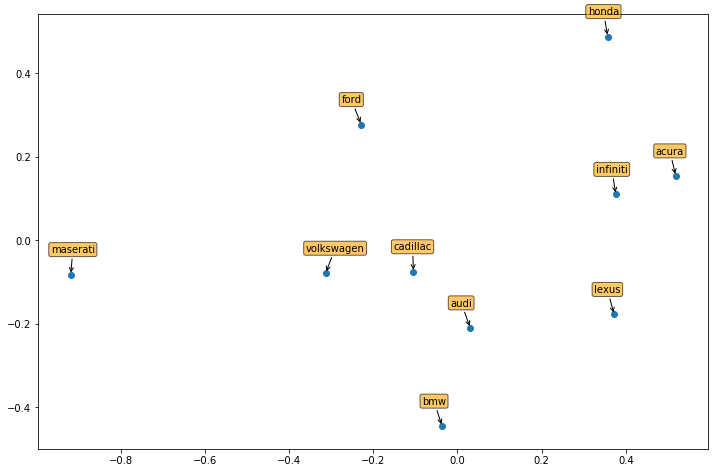

In [21]:
plot_mds(xdf,top_brands.word)

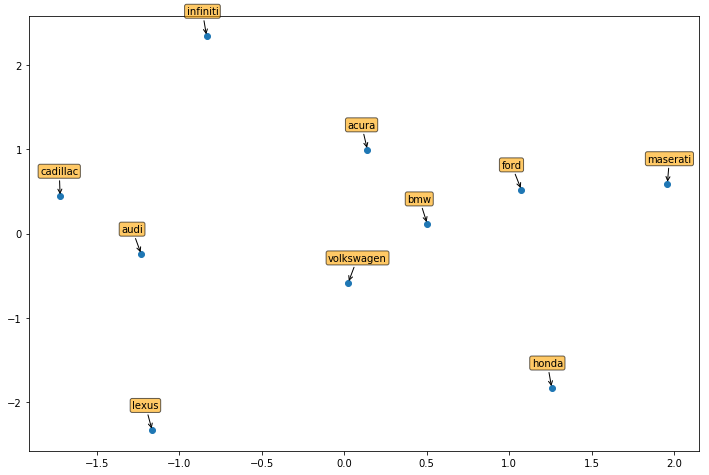

In [22]:
plot_mds(xdf,top_brands.word,1)

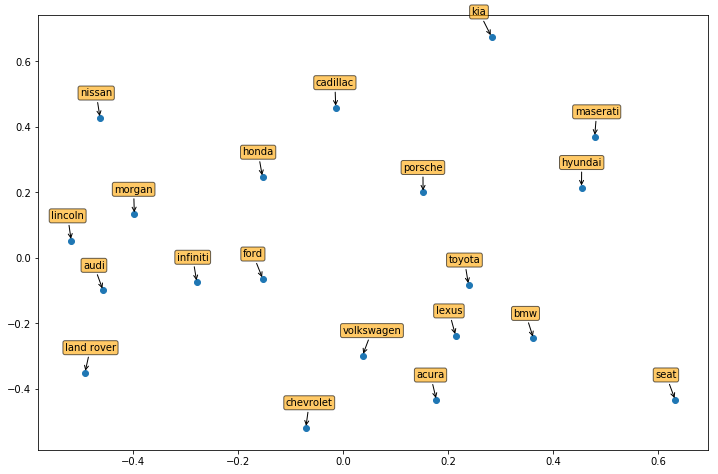

In [25]:
# plot MDS top 20
num_brands = 20
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
lift_score = [get_lift(x,y,df.post_cunique) for x in top_brands.word for y in top_brands.word] #if x!=y]
xdf = reshape(lift_score,(num_brands,num_brands))
plot_mds(xdf,top_brands.word)

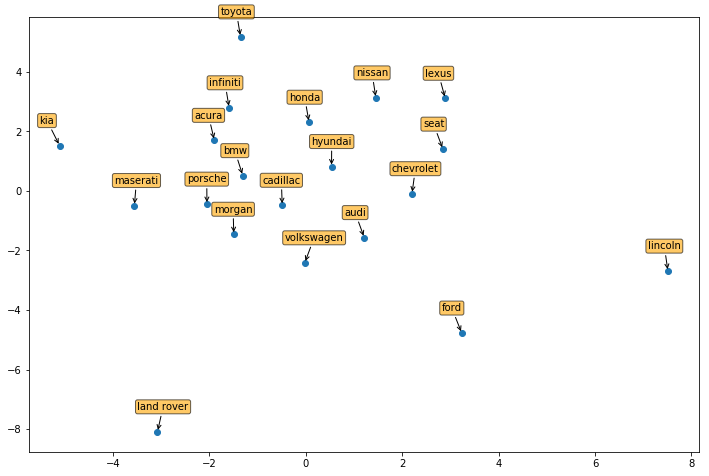

In [26]:
plot_mds(xdf,top_brands.word,1)

### Frequently mentioned attributes for cars

Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? 

In [27]:
# creating a dictionary for synonyms of product attributes based on most frequent words
prod_attributes = {'performance':['engine', 'engines', 'power', 'acceleration', 'quality', 'sport', 'mileage', 
                                  'torque', 'suspension', 'speed', 'sports', 'weight', 'suspension','hp'],
                   'transmission':['manual', 'auto', 'automatic', 'automatics', 'transmission','dsg'],
                   'wd':['awd', 'rwd', 'fwd', 'wheel', 'wheels','tires','steering','nif','suspension'],
                   'comfort':['class','interior','leather','brand','premium','seat','seats','experience','comfort','lux','comfortable'],
                   'price':['cheap', 'cheaper', 'costs', 'cost', 'economy', 'value','50k','45k','15k','35k','5k','10k','discount'],
                  }
#tires

In [28]:
def getKeysByValue(dictOfElements, valueToFind):
    for k,v  in dictOfElements.items():
        if valueToFind in v:
            return(k)
    return  valueToFind

def replace_attributes(s):
    return([getKeysByValue(prod_attributes,y) for y in s])

In [29]:
#replacing product attributes which are synonyms
df["post_attributes"] = df.post_cunique.map(replace_attributes)

In [30]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = prod_attributes.keys()
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]
formatted_lift_score = [ round(elem,2) for elem in lift_score ]
#round(lift_score,2)

In [31]:
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list )

,performance,transmission,wd,comfort,price
word,,,,,
bmw,1.63,1.59,1.00,1.60,1.68
acura,1.39,1.48,1.97,1.51,1.30
audi,1.57,1.72,1.63,2.17,1.74
volkswagen,1.56,1.65,1.49,1.73,1.40
infiniti,1.21,1.45,1.94,1.57,1.52
honda,1.09,1.31,2.19,1.34,1.28
ford,1.39,1.48,1.05,1.80,1.52
cadillac,1.53,1.39,1.05,2.33,1.60
lexus,1.63,1.97,1.34,2.36,1.85


### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   

In [32]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['ultimate','driving','machine']
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]

In [33]:
formatted_lift_score = [round(elem,2) for elem in lift_score ]
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list )

,ultimate,driving,machine
word,,,
bmw,2.70,1.82,2.08
acura,0.53,1.45,0.98
audi,1.45,1.97,1.32
volkswagen,1.10,1.79,0.98
infiniti,1.48,1.39,1.64
honda,0.81,1.47,0.38
ford,1.46,1.80,1.54
cadillac,3.65,1.70,3.09
lexus,3.08,1.99,2.21


In [34]:
# computing average
pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list))),index =top_brands.word , columns = product_list ).mean(axis=1)

word
bmw           2.200000
acura         0.986667
audi          1.580000
volkswagen    1.290000
infiniti      1.503333
honda         0.886667
ford          1.600000
cadillac      2.813333
lexus         2.426667
maserati      0.833333
dtype: float64

In [35]:
#checking with trigrams
from nltk import ngrams
n=3
df["post_trigrams"] = df.post_cunique.map(lambda x: [grams for grams in ngrams(x, n)])

C:\Users\abhin\Anaconda2\envs\Python3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


In [36]:
trigrams = df["post_trigrams"].sum()

In [37]:
trigrams_words = nltk.FreqDist(trigrams)

In [38]:
trigrams_words.most_common(10)

[(('2001', '2015', '2017'), 397),
 (('2015', '2017', 'awd'), 397),
 (('2017', 'awd', 'honda'), 397),
 (('awd', 'honda', 'infiniti'), 397),
 (('honda', 'infiniti', 'sh'), 397),
 (('infiniti', 'sh', 'touring'), 397),
 (('sh', 'touring', 'type'), 397),
 (('2018', '430i', 'gran'), 311),
 (('430i', 'gran', 'maserati'), 311),
 (('2018', 'acura', 'aspec'), 306)]

In [39]:
def get_conditional_lift(a,b,c,tokenized_data):
    p_ac = len([i for i in tokenized_data if a in i if c in i])
    p_bc = len([i for i in tokenized_data if c in i if b in i])
    p_c = len([i for i in tokenized_data if c in i])
    p_abc = len([i for i in tokenized_data if a in i if b in i if c in i])
    return float((p_abc * p_c)/(p_ac*p_bc))

In [61]:
num_brands = 5
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['ultimate','driving','machine']
conditional_lift = [get_conditional_lift(x,y,z,df.post_attributes) 
                    for x in top_brands.word for y in top_brands.word for z in product_list 
                    if x!=y]

In [62]:
formatted_lift_score = [round(elem,2) for elem in conditional_lift ]
index_list = [(x,y) for x in top_brands.word for y in top_brands.word if x!=y] 
pd.DataFrame(reshape(formatted_lift_score,(len(index_list),len(product_list))), index = index_list,columns = product_list)

,ultimate,driving,machine
"(bmw, acura)",1.11,1.03,1.11
"(bmw, audi)",0.92,1.21,0.81
"(bmw, volkswagen)",1.33,1.11,1.35
"(bmw, infiniti)",1.20,1.21,1.24
"(acura, bmw)",1.11,1.03,1.11
"(acura, audi)",1.44,1.48,2.03
"(acura, volkswagen)",1.17,1.44,0.56
"(acura, infiniti)",2.80,1.96,2.54
"(audi, bmw)",0.92,1.21,0.81
"(audi, acura)",1.44,1.48,2.03


### Advice to (i) product manager, and (ii) marketing/advertising manager of these brands based on attribute relations

### Most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [43]:
num_brands = 10
top_brands = rslt_unique[rslt_unique['word'].isin(car_models["make"])].nlargest(num_brands,'frequency')
product_list = ['hope','dream','love','desire','wish','aspire','pray']
lift_score = [get_lift(x,y,df.post_attributes) for x in top_brands.word for y in product_list]

In [44]:
#checking average scores per brand
formatted_lift_score = [round(elem,2) for elem in lift_score ]
asp_df = pd.DataFrame(reshape(formatted_lift_score,(num_brands,len(product_list)))
                      ,index =top_brands.word 
                      , columns = product_list)
asp_df

,hope,dream,love,desire,wish,aspire,pray
word,,,,,,,
bmw,1.56,2.00,1.73,1.32,2.09,1.13,2.06
acura,1.61,0.83,1.37,1.12,0.70,0.62,0.00
audi,1.77,3.83,1.89,2.30,1.70,2.74,1.79
volkswagen,1.98,1.71,1.43,1.10,1.49,1.92,1.10
infiniti,1.72,1.85,1.31,1.02,0.97,0.52,0.00
honda,1.56,3.03,1.29,0.93,1.06,1.70,0.00
ford,2.27,3.79,2.06,0.83,1.69,3.41,0.00
cadillac,2.66,4.06,1.39,0.60,2.38,0.00,0.00
lexus,1.58,2.62,1.24,1.60,1.09,2.94,0.00


In [45]:
#Taking an average
asp_df.mean(axis=1)

word
bmw           1.698571
acura         0.892857
audi          2.288571
volkswagen    1.532857
infiniti      1.055714
honda         1.367143
ford          2.007143
cadillac      1.584286
lexus         1.581429
maserati      1.120000
dtype: float64

In [46]:
# Give comment on analysis